In [2]:
! pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl (1.9 kB)
Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl (276.6 MB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import pickle
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings('ignore')

## Loading the three datasets one by one

In [2]:
totaldata = pd.read_csv("./data/totaldata.csv", index_col=0)
totaldata.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [3]:
SpamSubset = pd.read_csv(".\data\spamsubset.csv", index_col=0)
SpamSubset.drop(["Unnamed: 0"], axis=1, inplace=True)
SpamSubset = SpamSubset.reset_index().drop(['index'], axis = 1)
SpamSubset.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [4]:
Spam = pd.read_csv(".\data\spam1.csv", index_col=0)
Spam.head()

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


## Concatenating the three csv files

In [21]:
df = pd.concat([totaldata, SpamSubset, Spam], axis=0, ignore_index=True)
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


### Out of 18650 mails 11322 is labeled as 0 , i.e normal mail, and 7328 labeled as 1 , i.e spam mails.

In [6]:
# Class count
df.groupby("Label").count()

,Body
Label,
0,11322
1,7328


### Visualizing the data

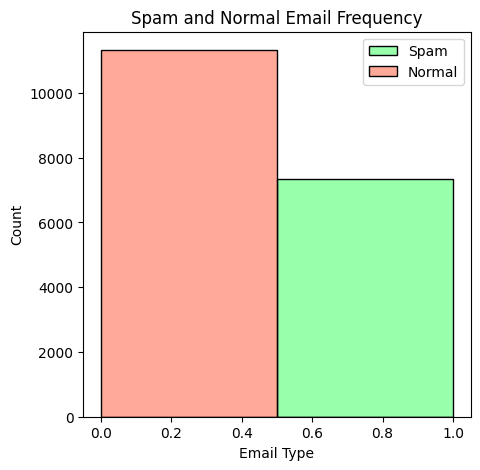

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
# Define custom colors for the histograms
custom_palette = ["#FF5733", "#33FF57"]  # Change these to your desired colors

sns.histplot(data=df, x='Label', hue='Label', bins=2, palette=custom_palette)
plt.xlabel("Email Type")
plt.title("Spam and Normal Email Frequency")
plt.legend(["Spam", "Normal"])
plt.show()


## Pre-processing

In [25]:
# lowercase, punctuation, removing numbers and special characters
#df.Body = df.Body.str.replace('\d', '')
df['Body'] = df['Body'].apply(lambda x: re.sub(r'\d+', '', x))
df.Body = df.Body.astype(str).map(lambda x:re.sub('\W+',' ', x))
df.Body = df.Body.map(lambda x:x.lower())
df.Body = df.Body.map(lambda x:x.translate(str.maketrans('', '', string.punctuation)))

In [26]:
df.iloc[0,0]

' save up to on life insurance why spend more than you have to life quote savings ensuring your family s financial security is very important life quote savings makes buying life insurance simple and affordable we provide free access to the very best companies and the lowest rates life quote savings is fast easy and saves you money let us help you get started with the best values in the country on new coverage you can save hundreds or even thousands of dollars by requesting a free quote from lifequote savings our service will take you less than minutes to complete shop and compare save up to on all types of life insurance click here for your free quote protecting your family is the best investment you ll ever make if you are in receipt of this email in error and or wish to be removed from our list please click here and type remove if you reside in any state which prohibits e mail solicitations for insurance please disregard this email '

In [27]:
# downloading the stopwards from nltk library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rickc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# removing stopwords such as prepositions
stopwords = stopwords.words('english')
df.Body = df.Body.map(lambda x: " ".join(_ for _ in x.split() if _ not in stopwords))

In [29]:
df.iloc[0,0]

'save life insurance spend life quote savings ensuring family financial security important life quote savings makes buying life insurance simple affordable provide free access best companies lowest rates life quote savings fast easy saves money let us help get started best values country new coverage save hundreds even thousands dollars requesting free quote lifequote savings service take less minutes complete shop compare save types life insurance click free quote protecting family best investment ever make receipt email error wish removed list please click type remove reside state prohibits e mail solicitations insurance please disregard email'

In [30]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rickc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
# lemmatizing the words
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df.Body = df.Body.map(lambda x: " ".join(lemmatizer.lemmatize(_) for _ in x.split()))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rickc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
df.iloc[0,0]

'save life insurance spend life quote saving ensuring family financial security important life quote saving make buying life insurance simple affordable provide free access best company lowest rate life quote saving fast easy save money let u help get started best value country new coverage save hundred even thousand dollar requesting free quote lifequote saving service take le minute complete shop compare save type life insurance click free quote protecting family best investment ever make receipt email error wish removed list please click type remove reside state prohibits e mail solicitation insurance please disregard email'

In [45]:
# Define a regular expression pattern to match French letters and symbols
pattern = r'[^\x00-\x7F]+'

# Use re.sub to replace matched patterns with an empty string
df['Body'] = df['Body'].apply(lambda x: re.sub(pattern, '', x))

In [46]:
df.head()

,Body,Label
0,save life insurance spend life quote saving en...,1
1,fight risk cancer http www adclick w p cfm pk ...,1
2,fight risk cancer http www adclick w p cfm pk ...,1
3,adult club offer free membership instant acces...,1
4,thought might like slim guaranteed lose lb day...,1


## Word Cloud For Spam Mails


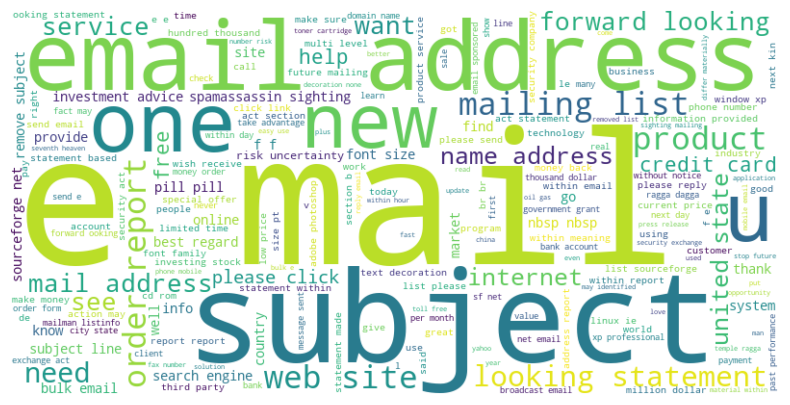

In [47]:
import wordcloud
import matplotlib.pyplot as plt

# Sample text data (replace this with your own text data)
text_data = ' '.join(df.loc[df['Label'] == 1, 'Body'].astype(str))

# Create a WordCloud object
wordcloud_obj = wordcloud.WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud from the text data
wordcloud_img = wordcloud_obj.generate(text_data)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis("off")
plt.show()


## Splitting the dataset into train and test datasets

In [48]:
# Assuming you have a DataFrame 'df' containing your data with 'Body' and 'Label' columns.

# Extract the 'Body' column as the features (X) and the 'Label' column as the target (Y).
X, Y = df.Body, df.Label

# Split the data into training and testing sets.
# The 'shuffle=True' argument ensures that the data is shuffled before splitting.
# By default, 75% of the data is used for training, and 25% for testing.
train_X, test_X, train_y, test_y = train_test_split(X, Y, shuffle=True)


## Tokenizing the textual data and encoding to sequences of integers

In [49]:
# Create a Tokenizer object with a vocabulary size of 12,000 words.
tokenizer_m = Tokenizer(num_words=12000)

# Fit the Tokenizer on the training text data.
tokenizer_m.fit_on_texts(train_X)

# Convert the text data to sequences of integers for both training and testing sets.
tokenized_train_X = tokenizer_m.texts_to_sequences(train_X)
tokenized_test_X = tokenizer_m.texts_to_sequences(test_X)

# Pad the sequences to ensure they all have the same length (maxlen=400).
# Padding is done with zeros at the end of sequences (padding='post').
train_X_ = pad_sequences(tokenized_train_X, padding='post', maxlen=400)
test_X_ = pad_sequences(tokenized_test_X, padding='post', maxlen=400)


## Fitting LogisticRegression

In [50]:
# Create a Logistic Regression classifier with specified parameters.
clf = LogisticRegression(random_state=1, max_iter=2000)

# Train the classifier on the training data.
clf.fit(train_X_, train_y)

# Evaluate the classifier's accuracy on the test data.
accuracy = clf.score(test_X_, test_y)


### Not that great score

In [51]:
accuracy

0.6139824147544499

## Using Repeated Stratified KFold cross validation

In [52]:
# Create a Logistic Regression model with specified random seed and maximum iterations
model = LogisticRegression(random_state=1, max_iter=2000)

# Define cross-validation settings using RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

# Define a search space for hyperparameters using a dictionary
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']  # Solvers for logistic regression
space['penalty'] = ['l1', 'l2', 'elasticnet']  # Regularization penalties
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]  # Inverse regularization strength values

# Create a GridSearchCV object to search for the best hyperparameters
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)

# Fit the GridSearchCV object to the training data to find the best hyperparameters
result = search.fit(train_X_, train_y)

# Print the best accuracy score achieved during the hyperparameter search
print('Best Score: %s' % result.best_score_)

# Print the best hyperparameters found by the search
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 9 folds for each of 63 candidates, totalling 567 fits
Best Score: 0.6177913409666931
Best Hyperparameters: {'C': 1e-05, 'penalty': 'l1', 'solver': 'liblinear'}


#### We see a minor increase in accuracy

## Using TF-IDF vectorization

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Create a pipeline with TF-IDF vectorization and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF vectorization
    ('clf', LogisticRegression(random_state=1, max_iter=2000))  # Logistic Regression classifier
])

# Define the hyperparameters and their values for grid search
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],  # Number of features (words) to consider
    'clf__C': [0.01, 0.1, 1.0],  # Inverse regularization strength
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=45)
# Create a grid search object with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(train_X, train_y)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(test_X, test_y)
print("Test Accuracy with Best Model: ", test_accuracy)


Fitting 25 folds for each of 9 candidates, totalling 225 fits
Best Parameters:  {'clf__C': 1.0, 'tfidf__max_features': 10000}
Best Accuracy:  0.9660708514662525
Test Accuracy with Best Model:  0.9689041389663307


##### A huge improvement

## RESULTS

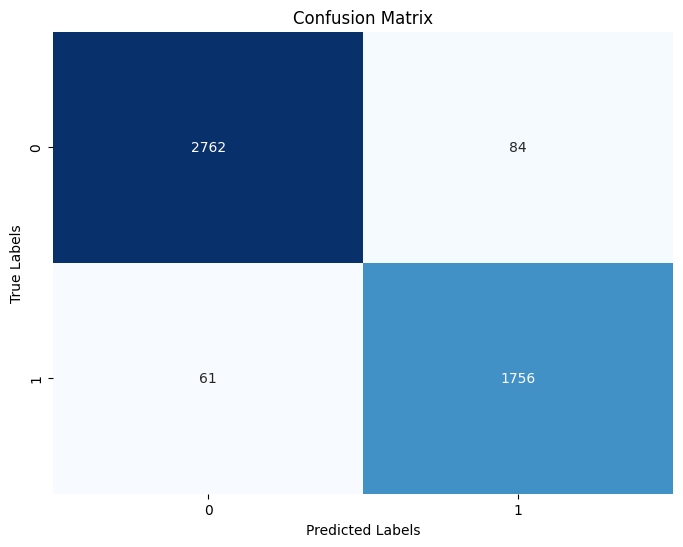

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      2846
     Class 1       0.95      0.97      0.96      1817

    accuracy                           0.97      4663
   macro avg       0.97      0.97      0.97      4663
weighted avg       0.97      0.97      0.97      4663



In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ... (previous code for training the model) ...

# Predict labels on the test data using the best model
y_pred = best_model.predict(test_X)

# Calculate the confusion matrix
confusion = confusion_matrix(test_y, y_pred)

# Calculate classification report with precision, recall, and F1-score
report = classification_report(test_y, y_pred, target_names=["Class 0", "Class 1"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(report)
